In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime

In [2]:
file_path_early =  r'D:\Ghana\IMERG_data\test_data\cropped\IMERG-ER'
file_path_final = r'D:\Ghana\IMERG_data\test_data\cropped\IMERG-FR'
file_path_earth_MSE = r'D:\Ghana\Output_data\experiments_adapted121\repotest\testOutput'
file_path_earth_balanced = r'D:\Ghana\Output_data\experiments_adapted131\repotest\testOutput'

In [3]:
# Traverse through all subdirectories and files in the given path
imerg_files_path_early = []
for root, dirs, files in os.walk(file_path_early):
    for file in files:
        if file.endswith(".HDF5"):
            imerg_files_path_early.append(os.path.join(root, file))

In [4]:
# Traverse through all subdirectories and files in the given path
imerg_files_path_final = []
for root, dirs, files in os.walk(file_path_final):
    for file in files:
        if file.endswith(".HDF5"):
            imerg_files_path_final.append(os.path.join(root, file))

In [5]:
metrics_list = ['csi', 'pod', 'sucr', 'bias']
#thresholds_list = [0.6, 1.7, 2.7, 5, 8.6, 15]
thresholds_list = [1.2, 3.4, 5.4, 10, 17.2, 30, 50]

In [6]:
def _threshold(target, pred, T):
    """
    Returns binary arrays t, p of the same shape as target & pred.
    t = 1 wherever target >= T.
    p = 1 wherever pred >= T.
    t and p are set to 0 wherever EITHER t or p are NaN.
    This is useful for counts that don't involve correct rejections.

    Parameters
    ----------
    target
        numpy.ndarray: Input target array
    pred
        numpy.ndarray: Input prediction array
    T
        numeric: Threshold value
    
    Returns
    -------
    t
        numpy.ndarray: Binary array for the target
    p
        numpy.ndarray: Binary array for the prediction
    """
    # Convert to binary arrays based on threshold T
    t = (target >= T).astype(float)
    p = (pred >= T).astype(float)

    # Identify NaN values in either target or pred
    is_nan = np.logical_or(np.isnan(target), np.isnan(pred))

    # Set binary arrays to 0 where NaNs are present
    t[is_nan] = 0
    p[is_nan] = 0

    return t, p


In [7]:
def _calc_hits_misses_fas(t, p):
    hits = np.sum(t * p)
    misses = np.sum(t * (1 - p))
    fas = np.sum((1 - t) * p)
    return hits, misses, fas

In [8]:
def calc_metrics(file_path_early, file_path_final, thrsholds_list):

    frame_hits = np.zeros(len(thresholds_list))
    frame_misses = np.zeros(len(thresholds_list))
    frame_fas = np.zeros(len(thresholds_list))
    
    eps = 1e-6

    with h5py.File(fr'{file_path_early}', 'r') as f_early:
        pred = f_early['Grid/precipitation'][:]

        with h5py.File(fr'{file_path_final}', 'r') as f_final:
            target = f_final['Grid/precipitation'][:]
        
            for i, threshold in enumerate(thresholds_list):
                t, p = _threshold(target, pred ,threshold)
                hits, misses, fas =  _calc_hits_misses_fas(t, p)
    
                # Add the results to the respective frames
                frame_hits[i] += hits
                frame_misses[i] += misses
                frame_fas[i] += fas
    
    pod_list = np.zeros(len(thresholds_list))
    csi_list = np.zeros(len(thresholds_list))
    sucr_list = np.zeros(len(thresholds_list))
    bias_list = np.zeros(len(thresholds_list))
    far_list = np.zeros(len(thresholds_list))
    
    for i in range(len(thresholds_list)):
        pod_list[i] = frame_hits[i] / (frame_hits[i] + frame_misses[i] + eps)
        csi_list[i] = frame_hits[i] / (frame_hits[i] + frame_misses[i] + frame_fas[i] + eps)
        sucr_list[i] = frame_hits[i] / (frame_hits[i] + frame_fas[i] + eps)
        bias_list[i] = (frame_hits[i] + frame_fas[i]) / (frame_hits[i] + frame_misses[i] + eps)
        far_list[i] = (frame_fas[i]) / (frame_fas[i] + frame_hits[i] + eps)
    return pod_list, csi_list, sucr_list, bias_list, far_list        

In [9]:
def extract_timestamp(filename):
    day = filename.split('.')[4].split('-')[0]
    hoday = filename.split('.')[4].split('-')[2][1:7]
    dt = datetime.strptime(day + hoday, "%Y%m%d%H%M%S")
    return dt

In [10]:
def calc_metrics(imerg_files_path_early, imerg_files_path_final, thresholds_list):
    """
    Calculate metrics for IMERG Early and Final files when timestamps match.
    
    Parameters:
        imerg_files_path_early (list): List of IMERG Early file paths.
        imerg_files_path_final (list): List of IMERG Final file paths.
        thresholds_list (list): List of thresholds for calculations.
    
    Returns:
        dict: Metrics for each threshold.
    """
    # Create a dictionary to map files by timestamp
    early_files_dict = {extract_timestamp(os.path.basename(f)): f for f in imerg_files_path_early}
    final_files_dict = {extract_timestamp(os.path.basename(f)): f for f in imerg_files_path_final}

    # Identify matching timestamps
    matching_timestamps = set(early_files_dict.keys()) & set(final_files_dict.keys())

    # Initialize metrics
    metrics = {
        'pod': np.zeros(len(thresholds_list)),
        'csi': np.zeros(len(thresholds_list)),
        'sucr': np.zeros(len(thresholds_list)),
        'bias': np.zeros(len(thresholds_list)),
        'far': np.zeros(len(thresholds_list))
    }

    # Accumulators for hits, misses, and false alarms
    frame_hits = np.zeros(len(thresholds_list))
    frame_misses = np.zeros(len(thresholds_list))
    frame_fas = np.zeros(len(thresholds_list))

    eps = 1e-6  # To prevent division by zero

    # Process matching files
    for timestamp in matching_timestamps:
        early_file = early_files_dict[timestamp]
        final_file = final_files_dict[timestamp]

        with h5py.File(fr'{early_file}', 'r') as f_early:
            pred = f_early['precipitationCal'][:]

            with h5py.File(fr'{final_file}', 'r') as f_final:
                target = f_final['precipitation'][:]
        
    # pred_subset = subset_imerg(early_file, min_lon, max_lon, min_lat, max_lat)
    # pred_subset = pred_subset['Grid/precipitationCal'][:]
        
    # target_subset = subset_imerg(final_file, min_lon, max_lon, min_lat, max_lat)
    # target_subset = target_subset['Grid/precipitation'][:]
            
                for i, threshold in enumerate(thresholds_list):
                    t, p = _threshold(target, pred,threshold)
                    hits, misses, fas =  _calc_hits_misses_fas(t, p)
            
                    # Add the results to the respective frames
                    frame_hits[i] += hits
                    frame_misses[i] += misses
                    frame_fas[i] += fas
        
    pod_list = np.zeros(len(thresholds_list))
    csi_list = np.zeros(len(thresholds_list))
    sucr_list = np.zeros(len(thresholds_list))
    bias_list = np.zeros(len(thresholds_list))
    far_list = np.zeros(len(thresholds_list))
    
    for i in range(len(thresholds_list)):
        pod_list[i] = frame_hits[i] / (frame_hits[i] + frame_misses[i] + eps)
        csi_list[i] = frame_hits[i] / (frame_hits[i] + frame_misses[i] + frame_fas[i] + eps)
        sucr_list[i] = frame_hits[i] / (frame_hits[i] + frame_fas[i] + eps)
        bias_list[i] = (frame_hits[i] + frame_fas[i]) / (frame_hits[i] + frame_misses[i] + eps)
        far_list[i] = (frame_fas[i]) / (frame_fas[i] + frame_hits[i] + eps)
    
    return pod_list, csi_list, sucr_list, bias_list, far_list        

In [11]:
def calc_metrics_output(file_path, thresholds_list):

    frame_hits = np.zeros(len(thresholds_list))
    frame_misses = np.zeros(len(thresholds_list))
    frame_fas = np.zeros(len(thresholds_list))
    
    eps = 1e-6
    
    for file in os.listdir(file_path):
        with h5py.File(fr'{file_path}//{file}', 'r') as f:
            target = f['y'][:]
            pred = f['y_hat'][:]
            for i, threshold in enumerate(thresholds_list):
                t, p = _threshold(target, pred ,threshold)
                hits, misses, fas =  _calc_hits_misses_fas(t, p)
    
                # Add the results to the respective frames
                frame_hits[i] += hits
                frame_misses[i] += misses
                frame_fas[i] += fas
    
    pod_list = np.zeros(len(thresholds_list))
    csi_list = np.zeros(len(thresholds_list))
    sucr_list = np.zeros(len(thresholds_list))
    bias_list = np.zeros(len(thresholds_list))
    far_list = np.zeros(len(thresholds_list))
    
    for i in range(len(thresholds_list)):
        pod_list[i] = frame_hits[i] / (frame_hits[i] + frame_misses[i] + eps)
        csi_list[i] = frame_hits[i] / (frame_hits[i] + frame_misses[i] + frame_fas[i] + eps)
        sucr_list[i] = frame_hits[i] / (frame_hits[i] + frame_fas[i] + eps)
        bias_list[i] = (frame_hits[i] + frame_fas[i]) / (frame_hits[i] + frame_misses[i] + eps)
        far_list[i] = (frame_fas[i]) / (frame_fas[i] + frame_hits[i] + eps)
    return pod_list, csi_list, sucr_list, bias_list, far_list        

In [12]:
pod_list_early, csi_list_early, sucr_list_early, bias_list_early, far_list_early = calc_metrics(imerg_files_path_early, imerg_files_path_final, thresholds_list)

In [13]:
print(np.round(pod_list_early, 4))
print(np.round(csi_list_early, 4))
print(np.round(sucr_list_early, 4))
print(np.round(bias_list_early, 4))
print(np.round(far_list_early, 4))

[0.6859 0.5889 0.5032 0.3541 0.2091 0.0884 0.    ]
[0.5163 0.3925 0.3049 0.1848 0.0927 0.0238 0.    ]
[0.6762 0.5406 0.4362 0.2787 0.1428 0.0315 0.    ]
[1.0144 1.0893 1.1537 1.2705 1.4644 2.8084 5.3333]
[0.3238 0.4594 0.5638 0.7213 0.8572 0.9685 1.    ]


In [14]:
print(np.round(np.mean(pod_list_early), 4))
print(np.round(np.mean(csi_list_early), 4))
print(np.round(np.mean(sucr_list_early), 4))
print(np.round(np.mean(bias_list_early), 4))
print(np.round(np.mean(far_list_early), 4))

0.3471
0.2164
0.3008
2.0192
0.6992


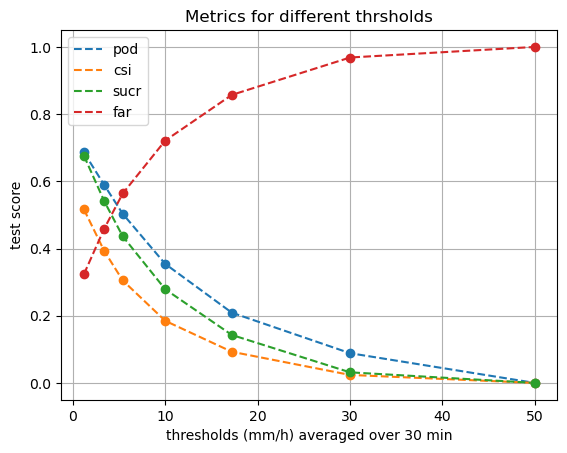

In [15]:
plt.grid()
plt.plot(thresholds_list, pod_list_early, linestyle = '--', label = 'pod')
plt.plot(thresholds_list, csi_list_early, linestyle = '--', label = 'csi')
plt.plot(thresholds_list, sucr_list_early, linestyle = '--', label = 'sucr')
plt.plot(thresholds_list, far_list_early, linestyle = '--', label = 'far')

plt.plot(thresholds_list, pod_list_early, 'o', color = 'C0')
plt.plot(thresholds_list, csi_list_early, 'o', color = 'C1')
plt.plot(thresholds_list, sucr_list_early, 'o', color = 'C2')
plt.plot(thresholds_list, far_list_early, 'o', color = 'C3')

plt.title('Metrics for different thrsholds')

plt.xlabel('thresholds (mm/h) averaged over 30 min')
plt.ylabel('test score')
plt.legend()
#plt.plot(thresholds_list, bias_list)
#plt.savefig('IMERG_EARLY_Final_metrics.png')

In [16]:
pod_list_mse, csi_list_mse, sucr_list_mse, bias_list_mse, far_list_mse = calc_metrics_output(file_path_earth_MSE, thresholds_list)

In [17]:
print(np.round(pod_list_mse, 4))
print(np.round(csi_list_mse, 4))
print(np.round(sucr_list_mse, 4))
print(np.round(bias_list_mse, 4))
print(np.round(far_list_mse, 4))

[0.751  0.6686 0.5709 0.3314 0.1068 0.0302 0.    ]
[0.6491 0.5416 0.4505 0.2742 0.0976 0.0284 0.    ]
[0.8271 0.7403 0.6811 0.6138 0.5318 0.3256 0.    ]
[0.9081 0.9031 0.8382 0.5399 0.2009 0.0927 0.0026]
[0.1729 0.2597 0.3189 0.3862 0.4682 0.6744 1.    ]


In [18]:
print(np.round(np.mean(pod_list_mse), 4))
print(np.round(np.mean(csi_list_mse), 4))
print(np.round(np.mean(sucr_list_mse), 4))
print(np.round(np.mean(bias_list_mse), 4))
print(np.round(np.mean(far_list_mse), 4))

0.3513
0.2916
0.5314
0.4979
0.4686


In [19]:
pod_list_balanced, csi_list_balanced, sucr_list_balanced, bias_list_balanced, far_list_balanced = calc_metrics_output(file_path_earth_balanced, thresholds_list)

In [20]:
print(np.round(pod_list_balanced, 4))
print(np.round(csi_list_balanced, 4))
print(np.round(sucr_list_balanced, 4))
print(np.round(bias_list_balanced, 4))
print(np.round(far_list_balanced, 4))

[0.8292 0.8081 0.7528 0.5682 0.2602 0.0719 0.    ]
[0.6661 0.572  0.5069 0.3921 0.2102 0.0665 0.    ]
[0.772  0.6619 0.6081 0.5586 0.5228 0.4733 0.    ]
[1.0742 1.2209 1.2379 1.0172 0.4977 0.1518 0.    ]
[0.228  0.3381 0.3919 0.4414 0.4772 0.5267 0.    ]


In [21]:
print(np.round(np.mean(pod_list_balanced), 4))
print(np.round(np.mean(csi_list_balanced), 4))
print(np.round(np.mean(sucr_list_balanced), 4))
print(np.round(np.mean(bias_list_balanced), 4))
print(np.round(np.mean(far_list_balanced), 4))

0.4701
0.3448
0.5138
0.7428
0.3433


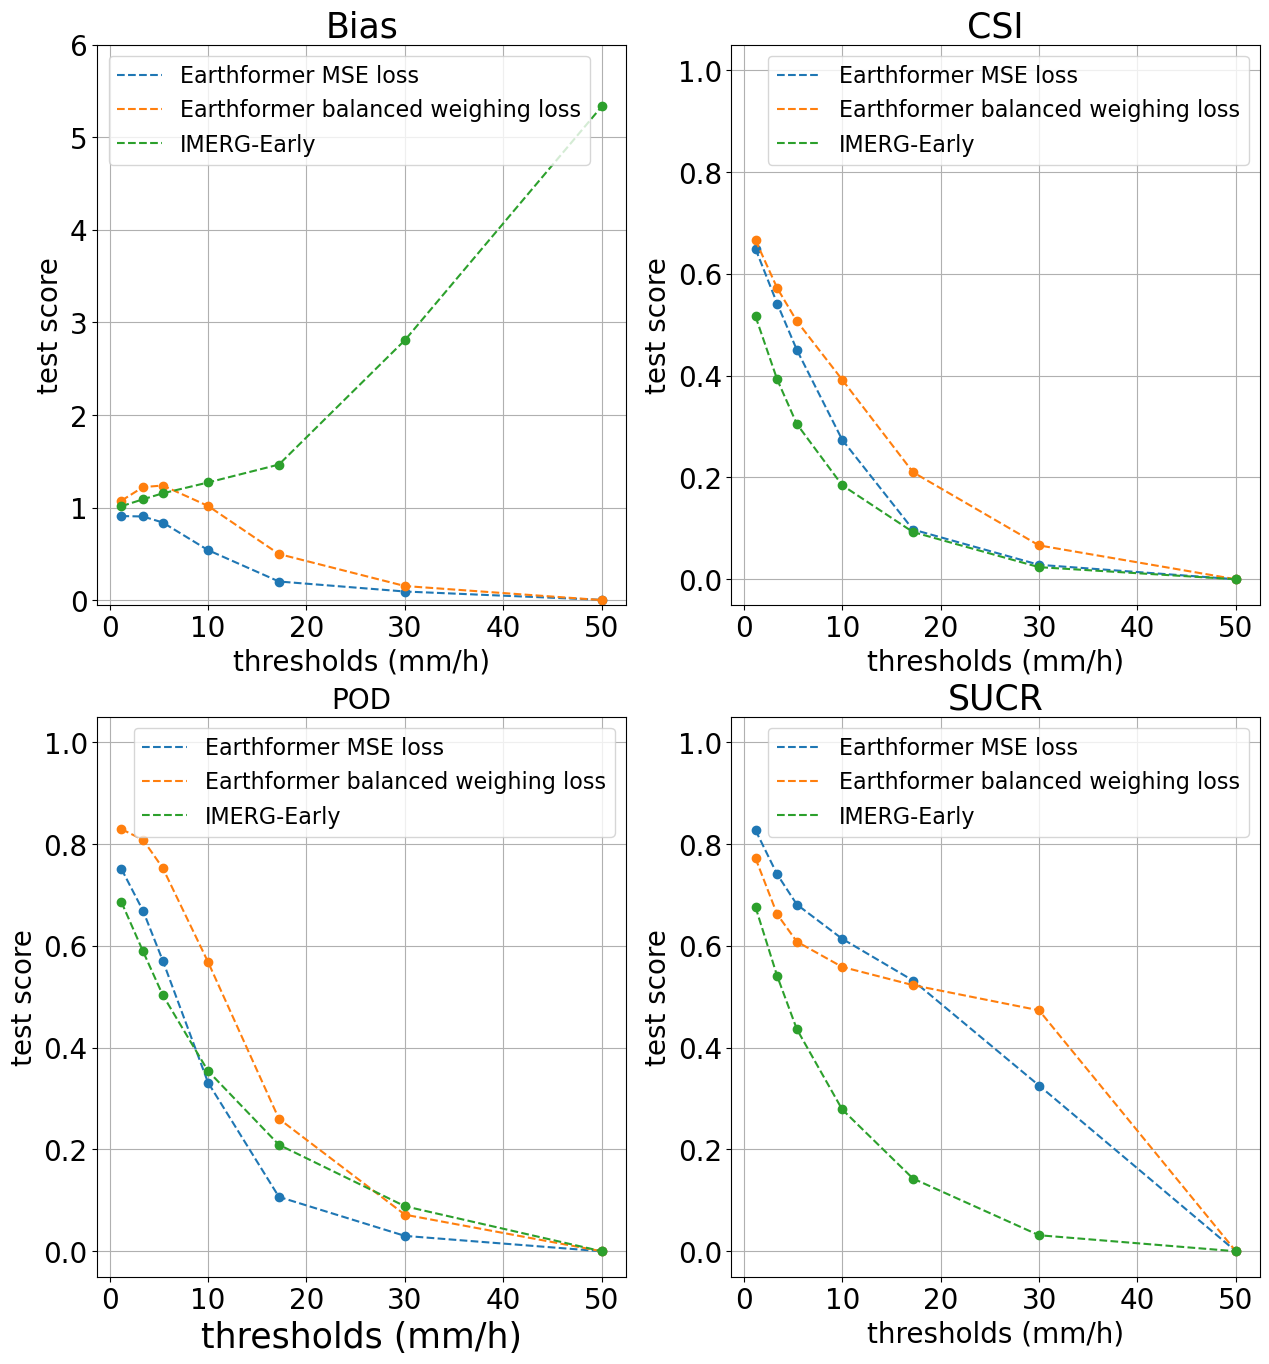

In [27]:
fig, ax = plt.subplots(2, 2, figsize = (15, 16))

ax[0, 0].plot(thresholds_list, bias_list_mse, linestyle = '--', label = 'Earthformer MSE loss')
ax[0, 0].plot(thresholds_list, bias_list_mse, 'o', color = 'C0')
ax[0, 0].plot(thresholds_list, bias_list_balanced, linestyle = '--', label = 'Earthformer balanced weighing loss')
ax[0, 0].plot(thresholds_list, bias_list_balanced, 'o', color = 'C1')
ax[0, 0].plot(thresholds_list, bias_list_early, linestyle = '--', label = 'IMERG-Early')
ax[0, 0].plot(thresholds_list, bias_list_early, 'o', color = 'C2')
ax[0, 0].set_title('Bias', fontsize = 25)
ax[0, 0].grid()
ax[0, 0].set_xlabel('thresholds (mm/h)', fontsize = 20)
ax[0, 0].set_ylabel('test score', fontsize = 20)
ax[0, 0].tick_params(axis='x', labelsize=20)  # Adjust x-tick label size
ax[0, 0].tick_params(axis='y', labelsize=20)  # Adjust y-tick label size
#ax[0, 0].set_xticks(np.linspace(0, max(thresholds_list), num=8))
ax[0, 0].set_ylim(-0.05, 6.)
ax[0, 0].legend(fontsize = 16)


ax[0, 1].plot(thresholds_list, csi_list_mse, linestyle = '--', label = 'Earthformer MSE loss')
ax[0, 1].plot(thresholds_list, csi_list_mse, 'o', color = 'C0')
ax[0, 1].plot(thresholds_list, csi_list_balanced, linestyle = '--', label = 'Earthformer balanced weighing loss')
ax[0, 1].plot(thresholds_list, csi_list_balanced, 'o', color = 'C1')
ax[0, 1].plot(thresholds_list, csi_list_early, linestyle = '--', label = 'IMERG-Early')
ax[0, 1].plot(thresholds_list, csi_list_early, 'o', color = 'C2')
ax[0, 1].set_title('CSI', fontsize = 25)
ax[0, 1].grid()
ax[0, 1].set_xlabel('thresholds (mm/h)', fontsize = 20)
ax[0, 1].set_ylabel('test score', fontsize = 20)
ax[0, 1].tick_params(axis='x', labelsize=20)  # Adjust x-tick label size
ax[0, 1].tick_params(axis='y', labelsize=20)  # Adjust y-tick label size
#ax[0, 1].set_xticks(np.linspace(0, max(thresholds_list), num=8))
ax[0, 1].set_ylim(-0.05, 1.05)
ax[0, 1].legend(fontsize = 16)

ax[1, 0].plot(thresholds_list, pod_list_mse, linestyle = '--', label = 'Earthformer MSE loss')
ax[1, 0].plot(thresholds_list, pod_list_mse, 'o', color = 'C0')
ax[1, 0].plot(thresholds_list, pod_list_balanced, linestyle = '--', label = 'Earthformer balanced weighing loss')
ax[1, 0].plot(thresholds_list, pod_list_balanced, 'o', color = 'C1')
ax[1, 0].plot(thresholds_list, pod_list_early, linestyle = '--', label = 'IMERG-Early')
ax[1, 0].plot(thresholds_list, pod_list_early, 'o', color = 'C2')
ax[1, 0].set_title('POD', fontsize = 20)
ax[1, 0].grid()
ax[1, 0].set_xlabel('thresholds (mm/h)', fontsize = 25)
ax[1, 0].set_ylabel('test score', fontsize = 20)
ax[1, 0].tick_params(axis='x', labelsize=20)  # Adjust x-tick label size
ax[1, 0].tick_params(axis='y', labelsize=20)  # Adjust y-tick label size
#ax[1, 0].set_xticks(np.linspace(0, max(thresholds_list), num=4))
ax[1, 0].set_ylim(-0.05, 1.05)
ax[1, 0].legend(fontsize = 16)

ax[1, 1].plot(thresholds_list, sucr_list_mse, linestyle = '--', label = 'Earthformer MSE loss')
ax[1, 1].plot(thresholds_list, sucr_list_mse, 'o', color = 'C0')
ax[1, 1].plot(thresholds_list, sucr_list_balanced, linestyle = '--', label = 'Earthformer balanced weighing loss')
ax[1, 1].plot(thresholds_list, sucr_list_balanced, 'o', color = 'C1')
ax[1, 1].plot(thresholds_list, sucr_list_early, linestyle = '--', label = 'IMERG-Early')
ax[1, 1].plot(thresholds_list, sucr_list_early, 'o', color = 'C2')
ax[1, 1].set_title('SUCR', fontsize = 25)
ax[1, 1].grid()
ax[1, 1].set_xlabel('thresholds (mm/h)', fontsize = 20)
ax[1, 1].set_ylabel('test score', fontsize = 20)
ax[1, 1].tick_params(axis='x', labelsize=20)  # Adjust x-tick label size
ax[1, 1].tick_params(axis='y', labelsize=20)  # Adjust y-tick label size
#ax[1, 1].set_xticks(np.linspace(0, max(thresholds_list), num=4))
ax[1, 1].set_ylim(-0.05, 1.05)
ax[1, 1].legend(fontsize = 16)

plt.savefig('metrics_comparison_target.png', bbox_inches = 'tight', dpi = 300)